In [1]:
import data_smoothing
import find_peaks
import peak_character

# Load TA data

In [2]:
data_nm, data_time, data_z = data_smoothing.load_data_csv('exp06_20180119 -t0 -chirp.csv', 500, 800)

# Smooth data

In [5]:
smooth_matx = data_smoothing.earth_smooth_matrix(data_nm, data_z)

/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


# Find Peaks

In [6]:
threshold = 0.75
mindist = 0
idx, height, fwhm = peak_character.peak_matrix(data_nm,smooth_matx, threshold, mindist)

In [10]:
idx.describe()

,0,1,2,3,4
count,456.000000,156.000000,39.000000,3.000000,2.000000
mean,198.682018,220.416667,223.717949,216.666667,226.500000
std,31.287708,21.777455,19.567627,7.505553,6.363961
min,45.000000,150.000000,168.000000,209.000000,222.000000
25%,172.750000,210.750000,218.500000,213.000000,224.250000
50%,214.500000,223.000000,229.000000,217.000000,226.500000
75%,223.000000,239.250000,241.000000,220.500000,228.750000
max,246.000000,247.000000,246.000000,224.000000,231.000000


In [13]:
height.describe()

,0,1,2,3,4
count,456.000000,156.000000,39.000000,3.000000,2.000000
mean,-0.000181,-0.000172,-0.000175,0.000151,0.000043
std,0.000197,0.000243,0.000303,0.000032,0.000257
min,-0.000823,-0.000935,-0.000954,0.000126,-0.000139
25%,-0.000290,-0.000336,-0.000311,0.000133,-0.000048
50%,-0.000167,-0.000147,-0.000121,0.000140,0.000043
75%,-0.000098,-0.000056,-0.000052,0.000164,0.000134
max,0.000474,0.000579,0.000354,0.000188,0.000225


In [25]:
data_nm.shape[0]

252

# Visualizer Function

In [26]:
import matplotlib.figure as fig
import matplotlib.pyplot as plt
import pandas as pd

def visualize(peak_dict, data_nm):
    for i in range(len(peak_dict)):
        df = pd.DataFrame(peak_dict['peak_%s' % i], 
        columns=['Position', 'Height', 'Width', 'Time'])
        
        plt.subplot(3, 1, 1)
        plt.plot(df['Time'], df['Height'], '.')
        plt.title('Peak %s Dynamics' % (i+1))
        plt.ylabel('Intensity')

        plt.subplot(3, 1, 2)
        plt.plot(df['Time'], df['Position'], '.')
        plt.ylabel('Position')
        plt.ylim((0, data_nm.shape[0]))

        plt.subplot(3, 1, 3)
        plt.plot(df['Time'], df['Width'], '.')
        plt.ylabel('Width')
        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()
    return

# Classify Peaks - KMeans

In [31]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def data_grouping(index_df, height_df, fwhm_df):
    peak_list = []
    
    for i in range(index_df.shape[0]):
        for j in range(index_df.shape[1]):
            peak_list.append(
            [index_df.loc[i,j], height_df.loc[i,j], fwhm_df.loc[i,j], i])
        
    all_points = pd.DataFrame(peak_list, 
    columns=['Position', 'Height', 'Width', 'Time'])
    fill_na = all_points.fillna(value=0)
    corrected_output = fill_na.drop(fill_na[abs(fill_na.Height) < 0.0002].index)
    corrected_output = corrected_output.reset_index(drop=True)
    
    return corrected_output

def KMeans_cluster_classifier(index_df, corrected_output):
    found_peak = index_df.shape[1]
    cluster = KMeans(n_clusters=found_peak).fit(corrected_output.iloc[:,:-2])
    print(cluster.labels_)
    print(cluster.cluster_centers_)
    peak_dict = {}
    
    for i in range(found_peak):
            peak_dict['peak_%s' % i] = []
            
    for j in range(corrected_output.shape[0]):
        peak = cluster.predict([corrected_output.values[j,:-2]])
        signal = corrected_output.loc[j][1]
        for k in range(found_peak):
            if (peak == k):
                peak_dict['peak_%s' % k].append(corrected_output.values[j])
                #print('found a match')

    return peak_dict

In [32]:
corrected_output = data_grouping(idx, height, fwhm)
corrected_output.describe()

,Position,Height,Width,Time
count,292.000000,292.000000,292.000000,292.000000
mean,211.578767,-0.000313,54.728914,348.647260
std,24.963010,0.000238,35.440339,202.045321
min,163.000000,-0.000954,4.793000,2.000000
25%,188.750000,-0.000426,25.262500,210.750000
50%,222.000000,-0.000314,40.932500,298.000000
75%,223.000000,-0.000236,88.416000,497.250000
max,247.000000,0.000579,135.411000,764.000000


In [33]:
peak_dict_KMeans = KMeans_cluster_classifier(idx, corrected_output)

[0 0 0 0 0 0 3 3 0 4 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 2 1 2 1 1 0 2 3 0 2 1 1
 0 2 1 1 3 1 2 3 0 2 1 1 1 3 1 1 0 2 1 2 0 2 1 1 0 2 1 2 0 2 3 0 2 1 1 1 0
 0 2 0 2 0 2 1 0 2 2 2 1 2 2 1 0 2 3 0 2 1 1 3 1 0 1 1 1 1 1 1 0 2 0 1 1 2
 1 0 2 0 2 0 2 0 2 1 1 1 2 0 1 1 1 0 2 0 2 1 4 0 2 0 1 1 2 1 0 1 1 3 0 2 0
 2 1 1 2 1 0 2 0 1 1 1 1 1 0 2 0 3 0 2 1 1 1 0 0 0 2 1 1 3 4 0 0 0 2 0 2 2
 0 0 1 3 2 0 2 2 2 0 0 0 2 0 0 0 0 4 0 3 0 2 0 0 0 0 0 3 0 2 0 0 0 0 3 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 3 0 2 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 3 3 0 0 0 0 0
 0 0 0 4 0 0 0 0 0 0 0 3 0 0 4 0 3 4 0 0 3 4 4 0 4 0 4 0 4 0 0 3 0]
[[ 2.22375000e+02 -2.60781863e-04]
 [ 1.71830769e+02 -3.79316647e-04]
 [ 2.42259259e+02 -4.35056474e-04]
 [ 1.91880000e+02 -2.72261333e-04]
 [ 2.07500000e+02 -9.05749791e-05]]


# Peak Dynamics With Classifying

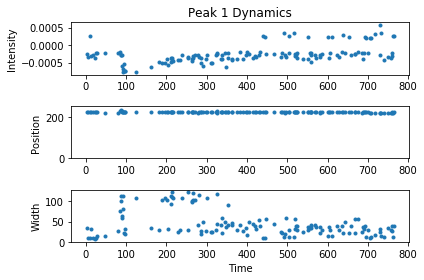

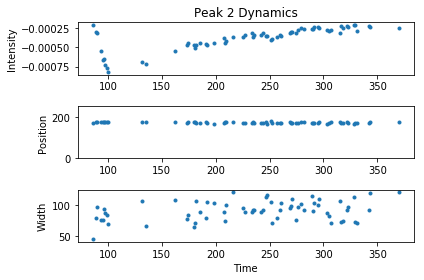

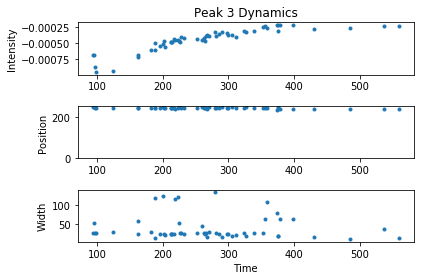

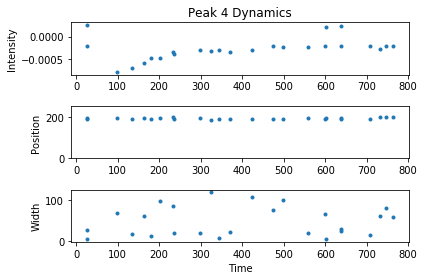

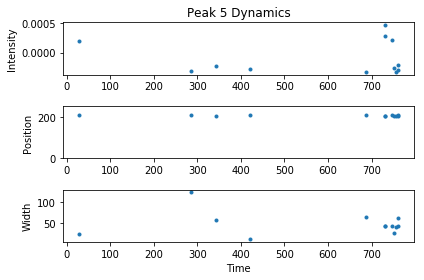

In [34]:
KMeans_output = visualize(peak_dict_KMeans, data_nm)

# Peak Dynamics Without Classifying

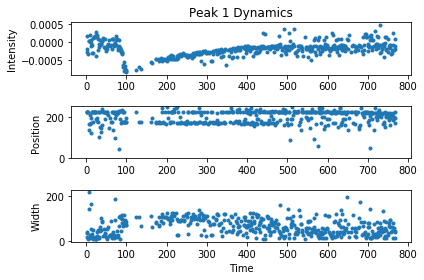

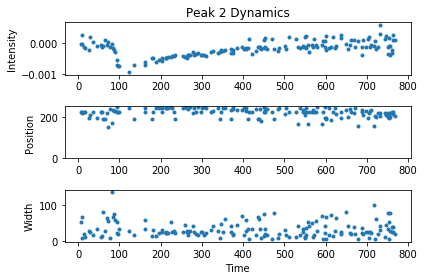

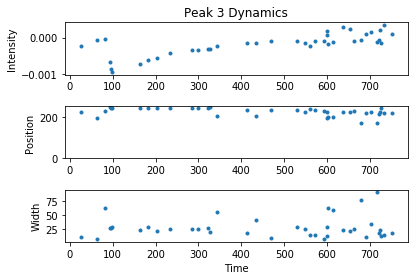

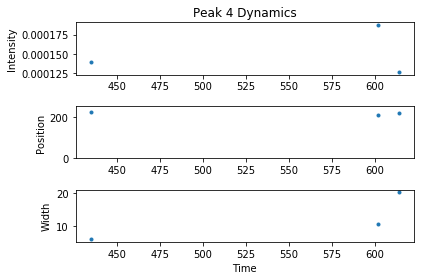

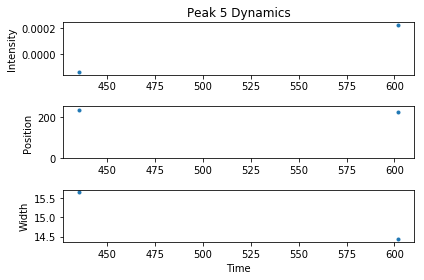

In [35]:
for i in range(idx.shape[1]):
        plt.subplot(3, 1, 1)
        plt.plot(height.loc[:, i], '.')
        plt.title('Peak %s Dynamics' % (i+1))
        plt.ylabel('Intensity')

        plt.subplot(3, 1, 2)
        plt.plot(idx.loc[:, i], '.')
        plt.ylabel('Position')
        plt.ylim((0, data_nm.shape[0]))

        plt.subplot(3, 1, 3)
        plt.plot(fwhm.loc[:, i], '.')
        plt.ylabel('Width')
        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()

# True Data:
* Peak 1: Intense peak at ~950nm (idx~20), maximum intensity ~-0.005, disappears by time 300.
* Peak 2: Broad peak at ~1100nm (idx~50), maximum intensity ~-0.0015, grows in at time 200 and persists for duration of experiment.

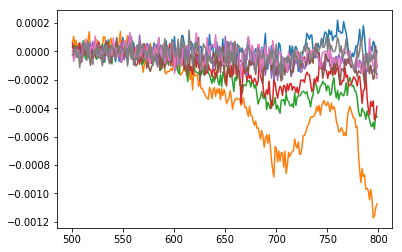

In [30]:
plt.plot(data_nm, data_z[:,1::100])